In [1]:
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
import glob
import csv
import numpy as np
import pandas as pd
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.compare import compare_survival
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=80)

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [2]:
train_data = pd.read_csv("../notebooks/train_features.csv", index_col=0)
train_labels = pd.read_csv("../notebooks/train_labels.csv", index_col=0)

In [3]:
corr = train_data.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
train_data = train_data.drop(train_data[to_drop], axis=1)

<ipython-input-3-d6fd05cc41a0>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


In [4]:
scaler = StandardScaler()
train_data_normalized = scaler.fit_transform(train_data)

In [5]:
len(train_data_normalized)

60

In [6]:
len(train_data_normalized[0])

304

In [7]:
columns_titles = ["Status", "Survival (in days)"]
train_labels = train_labels.reindex(columns=columns_titles)
train_labels["Status"] = train_labels["Status"].astype('bool')
train_labels.head()

,Status,Survival (in days)
1,False,361.0
2,False,194.0
3,False,816.0
4,True,365.0
5,False,679.0


In [8]:
val_data = pd.read_csv("../notebooks/val_features.csv", index_col=0)
val_labels = pd.read_csv("../notebooks/val_labels.csv", index_col=0)

val_data = val_data[train_data.columns]

In [9]:
val_data_normalized = scaler.transform(val_data)

In [10]:
len(val_data_normalized)

30

In [11]:
len(val_data_normalized[0])

304

In [12]:
columns_titles = ["Status", "Survival (in days)"]
val_labels = val_labels.reindex(columns=columns_titles)
val_labels["Status"] = val_labels["Status"].astype('bool')
val_labels.head()

,Status,Survival (in days)
1,True,880.0
2,False,3953.0
3,True,624.0
4,False,1503.0
5,True,91.0


In [13]:
y_train = []
for index, row in train_labels.iterrows():
    y_train.append((row["Status"], row["Survival (in days)"]))
dt = dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
y_train = np.array([tuple(row) for row in y_train], dtype=dt)
print(y_train)

[(False,  361.) (False,  194.) (False,  816.) ( True,  365.)
 (False,  679.) ( True,  627.) ( True,  820.) ( True,  730.)
 ( True,  317.) (False,  135.) (False, 1240.) ( True, 1278.)
 ( True, 1004.) ( True,  592.) (False,  116.) ( True, 1157.)
 ( True, 1891.) ( True, 1446.) ( True, 1279.) ( True,   92.)
 ( True,  883.) ( True, 1799.) (False,  576.) (False,  882.)
 (False, 1233.) ( True, 1583.) (False,  143.) ( True, 1369.)
 ( True,  455.) (False, 1278.) ( True, 1189.) (False, 1207.)
 (False, 2788.) ( True, 1249.) (False, 2616.) ( True, 1447.)
 ( True, 1562.) ( True, 2587.) ( True, 1033.) (False,  761.)
 (False,  137.) ( True,   61.) ( True,   84.) ( True, 1018.)
 ( True,   31.) ( True,  976.) ( True,  731.) ( True,    9.)
 ( True,   45.) ( True,  821.) (False,  130.) (False, 3525.)
 ( True,    9.) (False,  468.) ( True,  518.) (False, 2661.)
 (False,   84.) ( True,  395.) ( True,  575.) ( True,   53.)]


In [14]:
y_val = []
for index, row in val_labels.iterrows():
    y_val.append((row["Status"], row["Survival (in days)"]))
dt = dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
y_val = np.array([tuple(row) for row in y_val], dtype=dt)
print(y_val)

[( True,  880.) (False, 3953.) ( True,  624.) (False, 1503.)
 ( True,   91.) ( True, 1516.) (False,  268.) ( True, 1492.)
 (False, 1658.) (False,   98.) ( True,  949.) ( True,  304.)
 ( True, 1583.) ( True,  346.) (False,   16.) ( True,   90.)
 ( True,  976.) (False,  420.) ( True,  760.) ( True, 2009.)
 ( True,  759.) ( True,  394.) (False,  763.) ( True,   31.)
 ( True, 1155.) ( True, 1013.) ( True, 1162.) ( True, 1035.)
 (False,  722.) ( True, 2342.)]


In [15]:
estimator = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.05)
estimator.fit(train_data_normalized, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.05, l1_ratio=0.99)

In [16]:
estimator.score(train_data_normalized, y_train)
estimator.score(val_data_normalized, y_val)

0.535593220338983

In [17]:
# remove non-relevant features
count = 0
for index in range(0, len(estimator.coef_)):
    flag = -1
    for index1 in range(0, len(estimator.coef_[index])):
        if estimator.coef_[index][index1] > 0.01:
            flag = 1
            break
    if flag > 0:
        count += 1
print(count)

24


In [18]:
pred_surv_train = estimator.predict(train_data_normalized)
pred_surv_val = estimator.predict(val_data_normalized)
print(len(pred_surv_train))
print(len(pred_surv_val))

60
30


In [19]:
x_train_survival = []
x_train_survival_censored = []
x_val_survival = []
x_val_survival_censored = []
y_train_survival = []
y_val_survival = []
y_train_survival_censored = []
y_val_survival_censored = []
for index in range(0, len(y_train)):
    if y_train[index][0] == 1:
        x_train_survival.append(pred_surv_train[index])
        y_train_survival.append(y_train[index][1])
    else:
        x_train_survival_censored.append(pred_surv_train[index])
        y_train_survival_censored.append(y_train[index][1])
for index in range(0, len(y_val)):
    if y_val[index][0] == 1:
        x_val_survival.append(pred_surv_val[index])
        y_val_survival.append(y_val[index][1])
    else:
        x_val_survival_censored.append(pred_surv_val[index])
        y_val_survival_censored.append(y_val[index][1])
print(len(y_train_survival))
print(len(y_train_survival_censored))
print(len(y_val_survival))
print(len(y_val_survival_censored))

38
22
21
9


In [20]:
median_risk_score = np.median(pred_surv_train)
print(median_risk_score)

0.5265543310079273


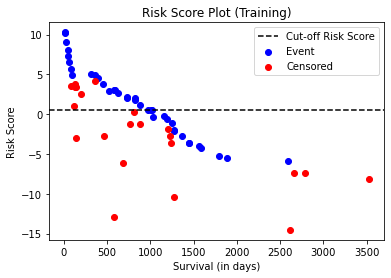

In [21]:
fig, ax = plt.subplots()

ax.scatter(y_train_survival, x_train_survival, color='b', label="Event")
ax.scatter(y_train_survival_censored, x_train_survival_censored, color='r', label="Censored")
ax.axhline(y=median_risk_score, color=[0,0,0], linestyle='--', label="Cut-off Risk Score")
ax.legend()
plt.title("Risk Score Plot (Training)")
plt.ylabel("Risk Score")
plt.xlabel("Survival (in days)")
plt.show()

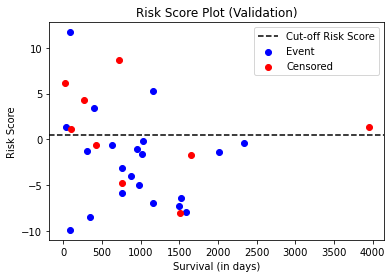

In [22]:
fig, ax = plt.subplots()

ax.scatter(y_val_survival, x_val_survival, color='b', label="Event")
ax.scatter(y_val_survival_censored, x_val_survival_censored, color='r', label="Censored")
ax.axhline(y=median_risk_score, color=[0,0,0], linestyle='--', label="Cut-off Risk Score")
ax.legend()
plt.title("Risk Score Plot (Validation)")
plt.ylabel("Risk Score")
plt.xlabel("Survival (in days)")
plt.show()

In [23]:
high_train_labels_status = []
high_train_labels_days = []
low_train_labels_status = []
low_train_labels_days = []
group_patients_train = []
for index, row in train_labels.iterrows():
    if pred_surv_train[index-1] > median_risk_score:
        group_patients_train.append(1)
        high_train_labels_status.append(row["Status"])
        high_train_labels_days.append(row["Survival (in days)"])
    else:
        group_patients_train.append(0)
        low_train_labels_status.append(row["Status"])
        low_train_labels_days.append(row["Survival (in days)"])
print(len(high_train_labels_status))
print(len(high_train_labels_days))
print(len(low_train_labels_status))
print(len(low_train_labels_days))

30
30
30
30


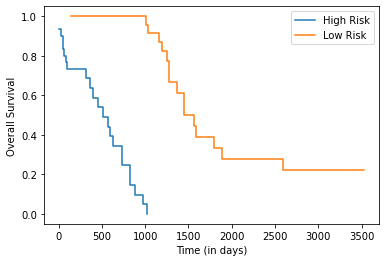

In [24]:
time_high, survival_prob_high = kaplan_meier_estimator(high_train_labels_status, high_train_labels_days)
time_low, survival_prob_low = kaplan_meier_estimator(low_train_labels_status, low_train_labels_days)

plt.step(time_high, survival_prob_high, where="post", label="High Risk")
plt.step(time_low, survival_prob_low, where="post", label="Low Risk")
plt.ylabel("Overall Survival")
plt.xlabel("Time (in days)")
plt.legend(loc="best")

In [25]:
high_val_labels_status = []
high_val_labels_days = []
low_val_labels_status = []
low_val_labels_days = []
group_patients_val = []
for index, row in val_labels.iterrows():
    if pred_surv_val[index-1] > median_risk_score:
        group_patients_val.append(1)
        high_val_labels_status.append(row["Status"])
        high_val_labels_days.append(row["Survival (in days)"])
    else:
        group_patients_val.append(0)
        low_val_labels_status.append(row["Status"])
        low_val_labels_days.append(row["Survival (in days)"])
print(len(high_val_labels_status))
print(len(high_val_labels_days))
print(len(low_val_labels_status))
print(len(low_val_labels_days))

9
9
21
21


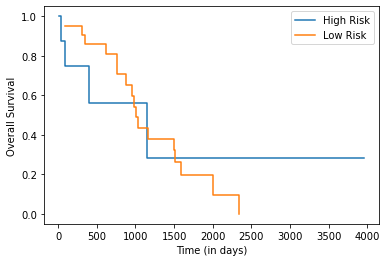

In [26]:
time_high, survival_prob_high = kaplan_meier_estimator(high_val_labels_status, high_val_labels_days)
time_low, survival_prob_low = kaplan_meier_estimator(low_val_labels_status, low_val_labels_days)

plt.step(time_high, survival_prob_high, where="post", label="High Risk")
plt.step(time_low, survival_prob_low, where="post", label="Low Risk")
plt.ylabel("Overall Survival")
plt.xlabel("Time (in days)")
plt.legend(loc="best")

In [27]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

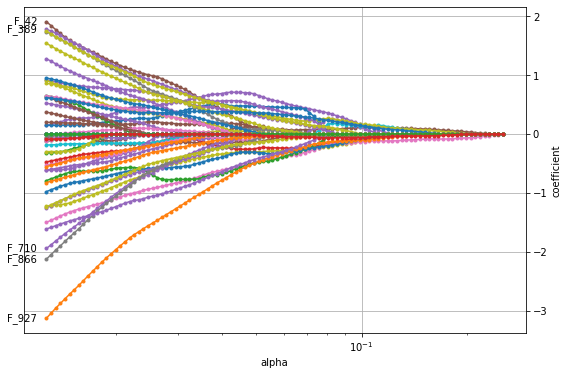

In [28]:
coefficients_lasso = pd.DataFrame(
    estimator.coef_,
    index=val_data.columns,
    columns=np.round(estimator.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)

In [29]:
_ = compare_survival(y_train, group_patients_train, return_stats=True)
print(_)

(57.20675924494824, 3.923205325334184e-14,        counts  observed   expected  statistic
group                                        
0          30        15  30.954659 -15.954659
1          30        23   7.045341  15.954659, array([[ 4.44966881, -4.44966881],
       [-4.44966881,  4.44966881]]))


In [30]:
_ = compare_survival(y_val, group_patients_val, return_stats=True)
print(_)

(0.0032473048234121114, 0.9545570419545416,        counts  observed  expected  statistic
group                                       
0          21        17  16.89909    0.10091
1           9         4   4.10091   -0.10091, array([[ 3.13577707, -3.13577707],
       [-3.13577707,  3.13577707]]))


In [31]:
print("Hazard Ratio = 2.326")
print("p-value = 0.017")

Hazard Ratio = 2.326
p-value = 0.017


In [32]:
est = 5.70210386143281
p_value = 0.017
z = -0.862 + np.sqrt(0.743 - 2.404*np.log(p_value))
se = np.abs(est / z)

u = est + 1.96*se
l = est - 1.96*se
print(u)
print(l)

10.389565507980759
1.0146422148848613
